In [18]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [19]:
mcari_img_dir = "/home/dat/Workspace/Thesis/lettuce_detector/data/raw/2017-10-27_Ortho/MCARI/lettuce"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Lettuce/2017-10-27.csv"

### Distribution of MCARI values

In [52]:
lettuce_mcari = {}
for fname in os.listdir(mcari_img_dir):
    img = np.asarray(Image.open(os.path.join(mcari_img_dir, fname)).convert("L"))
    mcari = (np.average(img) - 128) / 128
    lettuce_mcari[fname.split(".")[0]] = mcari

In [53]:
mcari_values = list(lettuce_mcari.values())

print("Average: %.4f" % np.average(mcari_values))
print("Std Dev: %.4f" % np.std(mcari_values))

Average: 0.0690
Std Dev: 0.0784


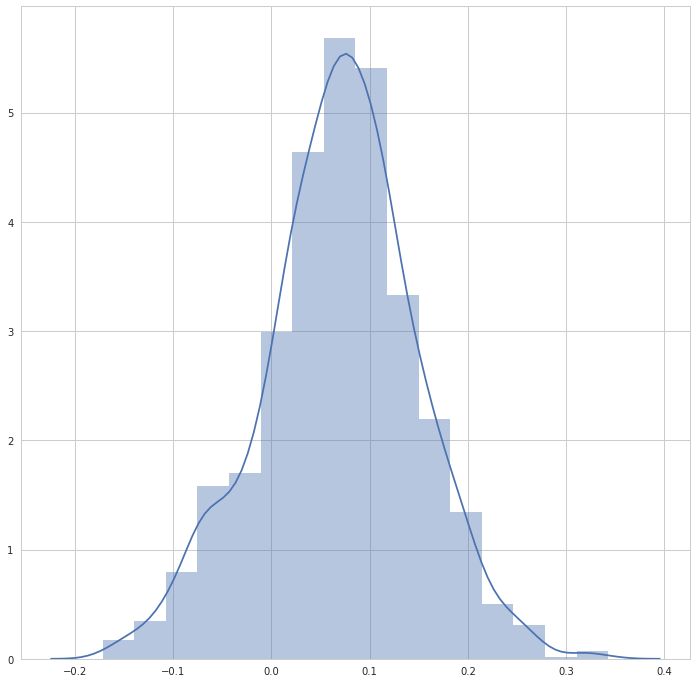

In [55]:
sns.distplot(mcari_values, bins=16)

In [56]:
nitrogen_mcari = {}
irrigation_mcari = {}
for treatment in [100, 50, 25, 0]:
    nitrogen_mcari[treatment] = []
    irrigation_mcari[treatment] = []
    for k, v in lettuce_mcari.items():
        if "N{}".format(treatment) in k:
            nitrogen_mcari[treatment].append(v)
        if "IR{}".format(treatment) in k:
            irrigation_mcari[treatment].append(v)

In [57]:
nitrogen_avg = {k:np.average(values) for k, values in nitrogen_mcari.items()}
nitrogen_stddev = {k:np.std(values) for k, values in nitrogen_mcari.items()}

print(nitrogen_avg)
print(nitrogen_stddev)

{100: 0.074563688903389158, 50: 0.076673479207134576, 25: 0.08844964992435711, 0: 0.037537428067591007}
{100: 0.078293219853644694, 50: 0.067059884442289081, 25: 0.06963283022579117, 0: 0.08701637671826333}


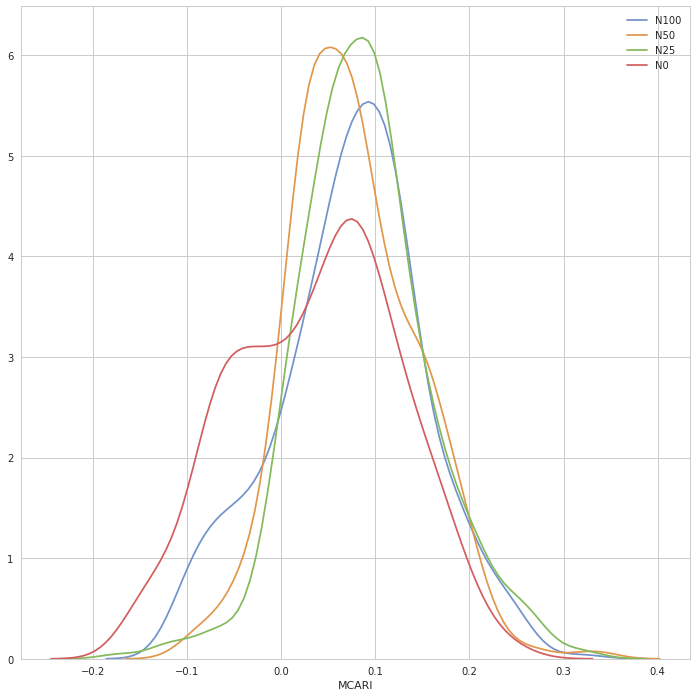

In [58]:
sns.distplot(nitrogen_mcari[100], bins=16, hist=False, color="#7293CB", label="N100")
sns.distplot(nitrogen_mcari[50],  bins=16, hist=False, color="#E1974C", label="N50")
sns.distplot(nitrogen_mcari[25],  bins=16, hist=False, color="#84BA5B", label="N25")
sns.distplot(nitrogen_mcari[0],   bins=16, hist=False, color="#D35E60", label="N0", axlabel="MCARI")

In [59]:
irrigation_avg = {k:np.average(values) for k, values in irrigation_mcari.items()}
irrigation_stddev = {k:np.std(values) for k, values in irrigation_mcari.items()}

print(irrigation_avg)
print(irrigation_stddev)

{100: 0.052179814728018269, 50: 0.084405496663664661, 25: 0.065598848631685386, 0: 0.073373506125189877}
{100: 0.078612674520746301, 50: 0.071373511485892438, 25: 0.082745182078064222, 0: 0.076993332753915719}


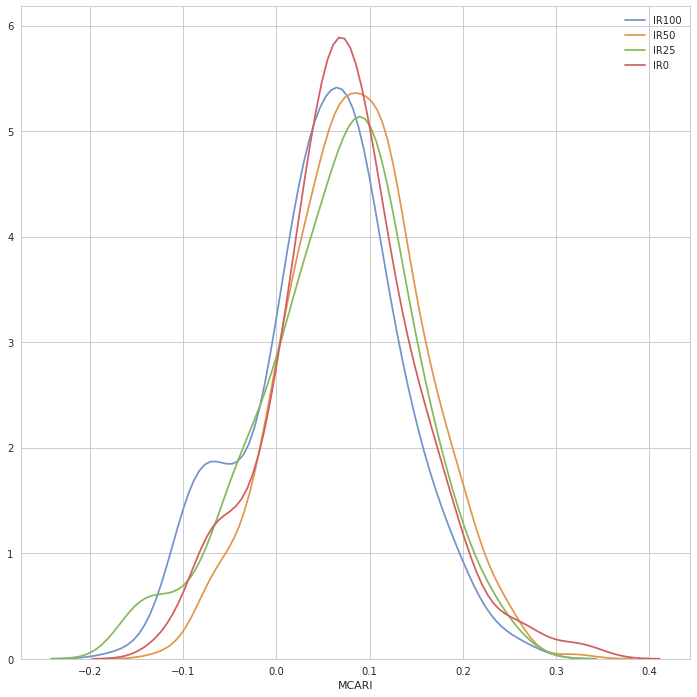

In [60]:
sns.distplot(irrigation_mcari[100], bins=16, hist=False, color="#7293CB", label="IR100")
sns.distplot(irrigation_mcari[50],  bins=16, hist=False, color="#E1974C", label="IR50")
sns.distplot(irrigation_mcari[25],  bins=16, hist=False, color="#84BA5B", label="IR25")
sns.distplot(irrigation_mcari[0],   bins=16, hist=False, color="#D35E60", label="IR0", axlabel="MCARI")

### Analyze ground data

In [61]:
df = pd.read_csv(csv_file)
df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
0,0,0,1,104,48.9,0.805878,-4.80,6,7
1,0,0,1,113,44.4,0.815393,NaN,6,7
2,0,0,2,104,48.8,0.839747,-4.24,4,6
3,0,0,2,113,53.5,0.819832,NaN,4,6
4,0,0,3,104,51.9,0.812323,-4.82,7,6


In [62]:
pre_df = {
    "Nitrogen": [],
    "Irrigation": [],
    "Replication": [],
    "Plant Number": [],
    "uav_mcari": [],
}
for k, v in lettuce_mcari.items():
    nitrogen = int(re.search("N(.*)IR.*", k).group(1))
    irrigation = int(re.search(".*IR(.*)Rep.*", k).group(1))
    replication = int(re.search(".*Rep(.*)_", k).group(1))
    number = int(re.search(".*_(.*)", k).group(1))
    
    if number == 104 or number == 113:
        pre_df["Nitrogen"].append(nitrogen)
        pre_df["Irrigation"].append(irrigation)
        pre_df["Replication"].append(replication)
        pre_df["Plant Number"].append(number)
        pre_df["uav_mcari"].append(v)

mcari_df = pd.DataFrame(data=pre_df)

In [63]:
merged_df = pd.merge(df, mcari_df, on=["Nitrogen", "Irrigation", "Replication", "Plant Number"])
merged_df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,uav_mcari
0,0,0,1,104,48.9,0.805878,-4.80,6,7,-0.013802
1,0,0,1,113,44.4,0.815393,NaN,6,7,0.077474
2,0,0,2,104,48.8,0.839747,-4.24,4,6,0.045218
3,0,0,2,113,53.5,0.819832,NaN,4,6,0.023888
4,0,0,3,104,51.9,0.812323,-4.82,7,6,-0.030629


In [66]:
print("UAV MCARI & Chlorophyll:", stats.pearsonr(merged_df["uav_mcari"], merged_df["Chlorophyll"])[0])
print("UAV MCARI & NDVI:", stats.pearsonr(merged_df["uav_mcari"], merged_df["NDVI"])[0])
print("UAV MCARI & Height:", stats.pearsonr(merged_df["uav_mcari"], merged_df["Average Height"])[0])
print("UAV MCARI & Leaf Count:", stats.pearsonr(merged_df["uav_mcari"], merged_df["Average Leaf Count"])[0])
print("UAV MCARI & WP:", stats.pearsonr(merged_df.dropna()["uav_mcari"], merged_df.dropna()["WP"])[0])

UAV MCARI & Chlorophyll: -0.056664596655
UAV MCARI & NDVI: 0.0933161744687
UAV MCARI & Height: -0.059620683887
UAV MCARI & Leaf Count: -0.178638377372
UAV MCARI & WP: 0.115785807968


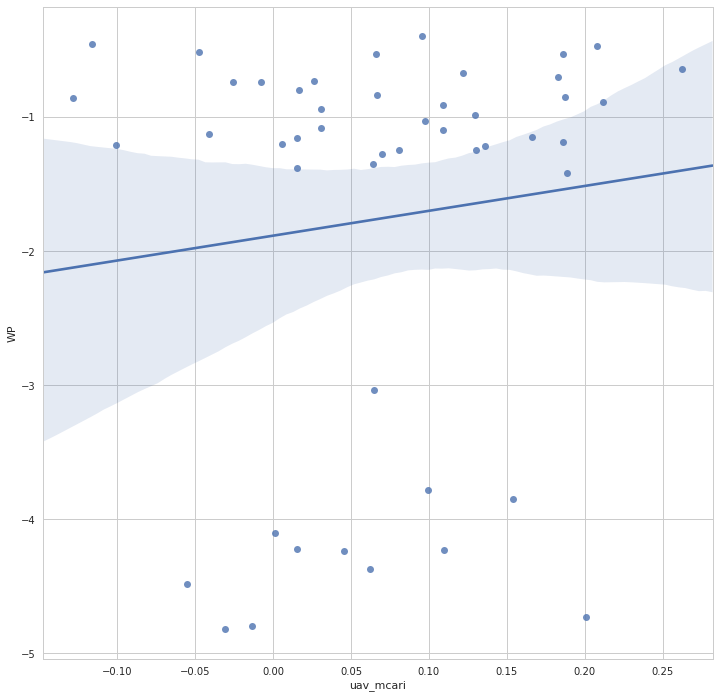

In [65]:
sns.regplot(x=merged_df["uav_mcari"], y=merged_df["WP"])